## Import Data from Folder

In [ ]:
import csv
from sklearn.model_selection import train_test_split

# Load data from file.
lines = []
with open('./data/driving_log.csv') as csvfile:
    reader = csv.reader(csvfile)
    for line in reader:
        lines.append(line)
header = lines.pop(0)

# Split data into training and validation set.
train_samples, validation_samples = train_test_split(lines, test_size=0.2)

## Generator Code

In [5]:
import cv2
import numpy as np
import sklearn
from matplotlib import pyplot as plt
from sklearn.utils import shuffle

%matplotlib inline

def generator(samples, batch_size=32):
    """Data Generator to Prevent Overflow
    
    Returns:
      List, images of left/right/center camera.
      List, steering angles.
    """
    steering_bias_left = 0.2
    steering_bias_right = -0.2
    num_samples = len(samples)
    while 1: # Loop forever so the generator never terminates
        shuffle(samples)
        for offset in range(0, num_samples, batch_size):
            batch_samples = samples[offset:offset+batch_size]

            images = []
            measurements = []
            for batch_sample in batch_samples:
                # Collect Images & Measurements.
                current_dir = './data/IMG/'
                image_c = cv2.imread(current_dir + batch_sample[0].split('/')[-1])
                image_l = cv2.imread(current_dir + batch_sample[1].split('/')[-1])
                image_r = cv2.imread(current_dir + batch_sample[2].split('/')[-1])
                measurement_c = float(batch_sample[3])
                measurement_l = float(measurement_c + steering_bias_left)
                measurement_r = float(measurement_c + steering_bias_right)

                # Add Normal & Mirrored Images.
                images.append(image_c)
                images.append(np.fliplr(image_c))
                images.append(image_l)
                images.append(np.fliplr(image_l))
                images.append(image_r)
                images.append(np.fliplr(image_r))

                # Add Normal & Mirrored Steering.
                measurements.append(measurement_c)
                measurements.append(-measurement_c)
                measurements.append(measurement_l)
                measurements.append(-measurement_l)
                measurements.append(measurement_r)
                measurements.append(-measurement_r)

            # Set data into array.
            X_train = np.array(images)
            y_train = np.array(measurements)
            yield sklearn.utils.shuffle(X_train, y_train)

# Compile and train the model using the generator function
train_generator = generator(train_samples, batch_size=32)
validation_generator = generator(validation_samples, batch_size=32)

## Populate Images and Measurements

In [ ]:
# Populate measurements into array.
STEERING_BIAS_L = 0.2
STEERING_BIAS_R = -0.2

images = []
measurements = []
for line in lines:
    # Collect Images & Measurements.
    current_dir = './data/IMG/'
    image_c = cv2.imread(current_dir + line[0].split('/')[-1])
    image_l = cv2.imread(current_dir + line[1].split('/')[-1])
    image_r = cv2.imread(current_dir + line[2].split('/')[-1])
    measurement_c = float(line[3])
    measurement_l = measurement_c + STEERING_BIAS_L
    measurement_r = measurement_c + STEERING_BIAS_R
    
    # Add Normal & Mirrored Images.
    images.append(image_c)
    images.append(np.fliplr(image_c))
    images.append(image_l)
    images.append(np.fliplr(image_l))
    images.append(image_r)
    images.append(np.fliplr(image_r))
    
    # Add Normal & Mirrored Steering.
    measurements.append(measurement_c)
    measurements.append(-measurement_c)
    measurements.append(measurement_l)
    measurements.append(-measurement_l)
    measurements.append(measurement_r)
    measurements.append(-measurement_r)
    

X_train = np.array(images)
y_train = np.array(measurements)

print('Complete')

## Model Architecture.

In [6]:
from keras.models import Sequential
from keras.layers import Activation, Cropping2D, Dense
from keras.layers import Dropout, Flatten, Lambda
from keras.layers import Convolution2D, MaxPooling2D

# Model Architecture.
model = Sequential()

# Preprocess Images.
model.add(Lambda(lambda x: x / 255.0 - 0.5, input_shape=(160, 320, 3)))
model.add(Cropping2D(cropping=((70,25),(0,0))))

# LeNet Architecture.
#model.add(Convolution2D(6,5,5,activation="relu"))
#model.add(MaxPooling2D())
#model.add(Convolution2D(6,5,5,activation="relu"))
#model.add(MaxPooling2D())
#model.add(Dropout(0.50))
#model.add(Flatten())
#model.add(Dense(120))
#model.add(Dropout(0.50))
#model.add(Dense(84))
#model.add(Dense(1))

# NVIDIA Architecture.
model.add(Convolution2D(24, 5, 5, subsample=(2,2), activation='relu'))
model.add(Convolution2D(36, 5, 5, subsample=(2,2), activation='relu'))
model.add(Dropout(0.50))
model.add(Convolution2D(48, 5, 5, subsample=(2,2), activation='relu'))
model.add(Convolution2D(64, 3, 3, activation='relu'))
model.add(Convolution2D(64, 3, 3, activation='relu'))
model.add(Dropout(0.50))
model.add(Flatten())
model.add(Dense(100))
model.add(Dropout(0.50))
model.add(Dense(50))
model.add(Dense(10))
model.add(Dense(1))

#https://devblogs.nvidia.com/parallelforall/deep-learning-self-driving-cars/

## Train the Model.

In [ ]:
# Compile & Fit Model.
model.compile(loss='mse', optimizer='adam')
history_object = model.fit(X_train, y_train, validation_split=0.2, shuffle=True, nb_epoch=3)

# Save Training Model
model.save('model_dropout.h5')
print('Model Saved.')

## Generator Code

In [8]:
model.compile(loss='mse', optimizer='adam')
history_object = model.fit_generator(train_generator, samples_per_epoch=len(train_samples)*6, 
                    validation_data=validation_generator, nb_val_samples=len(validation_samples)*6,
                    nb_epoch=3)

Epoch 1/3
1986/1986 [==============================] - 30s - loss: 0.0341 - val_loss: 0.0275
Epoch 2/3
1986/1986 [==============================] - 31s - loss: 0.0288 - val_loss: 0.0258
Epoch 3/3
1986/1986 [==============================] - 32s - loss: 0.0258 - val_loss: 0.0235


In [9]:
# Save Training Model
model.save('model_dropout.h5')
print('Model Saved.')

Model Saved.


## Visualizing Loss

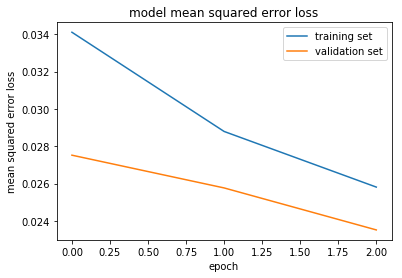

In [10]:
plt.plot(history_object.history['loss'])
plt.plot(history_object.history['val_loss'])
plt.title('model mean squared error loss')
plt.ylabel('mean squared error loss')
plt.xlabel('epoch')
plt.legend(['training set', 'validation set'], loc='upper right')
plt.show()